Chapter 15 and Week 10 homework from [Winter 2020 of Statistical Rethinking](https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework) using Python. A public repo using `pmyc3` has been created [here](https://github.com/pymc-devs/resources/tree/master/Rethinking_2) that also uses Python.

In [136]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import daft
from causalgraphicalmodels import CausalGraphicalModel

from scipy.optimize import curve_fit

<IPython.core.display.Javascript object>

In [3]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [4]:
sns.set_context("talk")

<IPython.core.display.Javascript object>

In [5]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Waffle divorce problems

In [6]:
DATA = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking/Data/'
df_divorce = pd.read_csv(DATA + 'WaffleDivorce.csv', sep=';')
df_divorce.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


<IPython.core.display.Javascript object>

In [17]:
df_divorce['Marriage'].max()

30.7

<IPython.core.display.Javascript object>

why scale standard error by dividing against standard deviation of `divorce`?

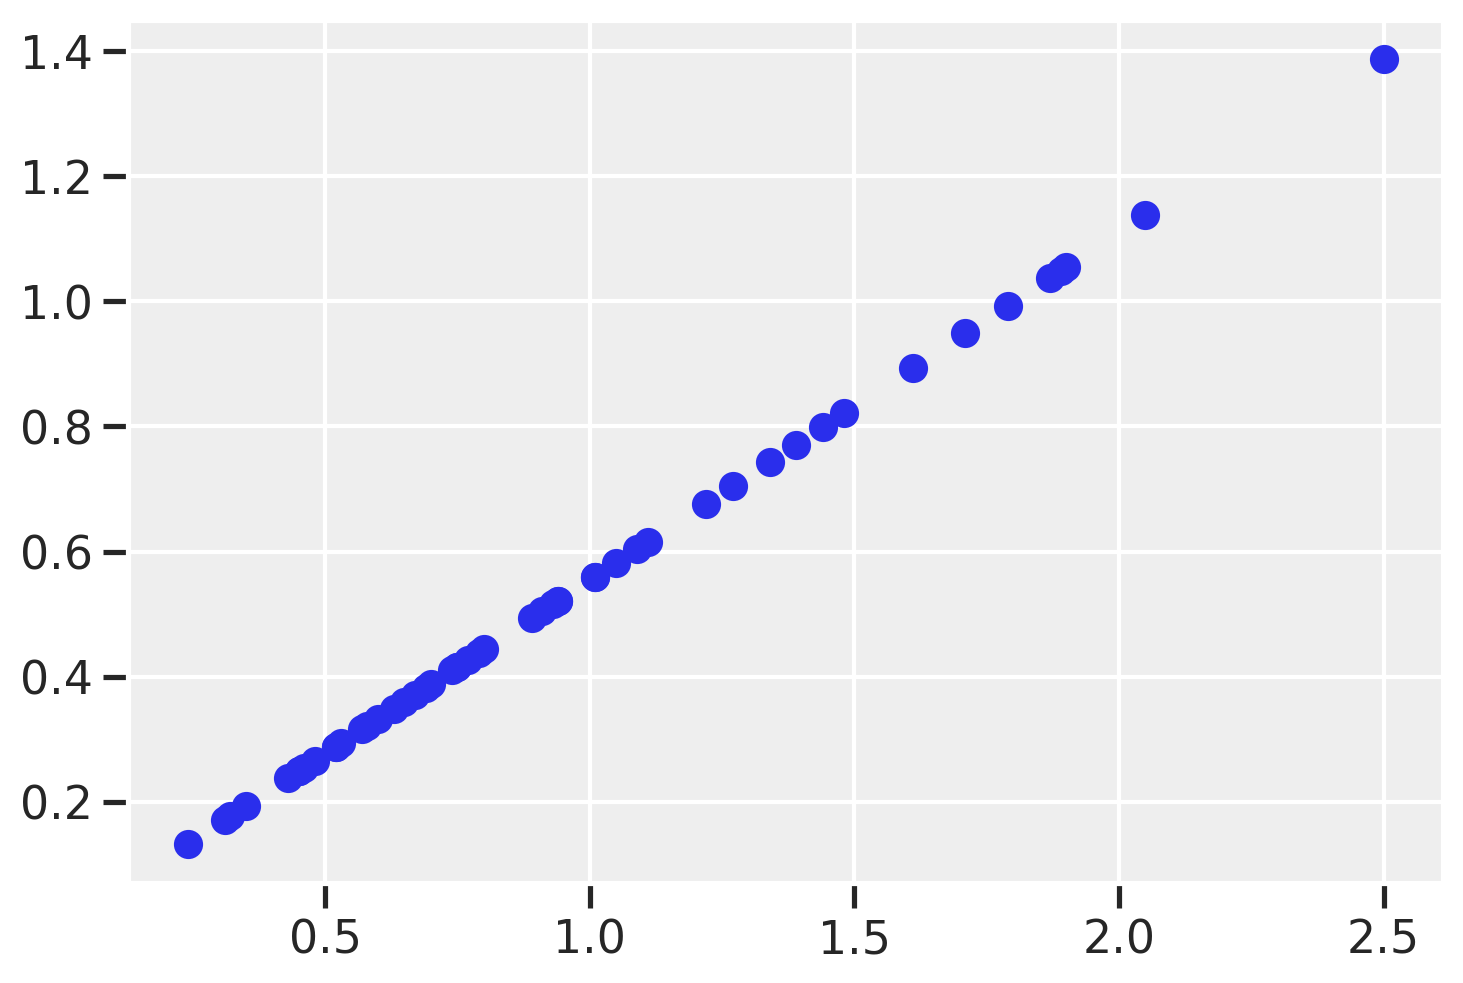

<IPython.core.display.Javascript object>

In [11]:
plt.scatter(df_divorce['Divorce SE'], (df_divorce['Divorce SE'] / np.std(df_divorce['Divorce'])))

In [7]:
df_divorce['Divorce SE'] / np.std(df_divorce['Divorce'])

0     0.438277
1     1.137301
2     0.410538
3     0.676833
4     0.133147
5     0.521494
6     0.427181
7     0.771145
8     1.048536
9     0.177530
10    0.321773
11    0.704572
12    0.582520
13    0.249651
14    0.349512
15    0.504851
16    0.604711
17    0.416086
18    0.493755
19    0.821076
20    0.382799
21    0.288486
22    0.294034
23    0.332868
24    0.560329
25    0.371703
26    0.948675
27    0.521494
28    0.893197
29    0.255199
30    0.615807
31    0.171982
32    0.266295
33    0.798884
34    0.249651
35    0.560329
36    0.443825
37    0.238556
38    0.993058
39    0.388347
40    1.386952
41    0.416086
42    0.194173
43    0.515946
44    1.037440
45    0.288486
46    0.360608
47    0.743406
48    0.316225
49    1.054083
Name: Divorce SE, dtype: float64

<IPython.core.display.Javascript object>

In [8]:
np.std(df_divorce['Divorce SE'])

0.5200872619089992

<IPython.core.display.Javascript object>

# 15M1

Using the mathematical form of the imputation model in the chapter, explain what is being
assumed about how the missing values were generated.

It depends on the DAG.

- missing completely at random doesn't change the overall distribution (nothing points to missingness)
- missing at random (missigness confounds but can be corrected?)
- missing not at random (missingess confounds but can't be corrected?)

# 15M2

Reconsider the primate milk missing data example from the chapter. This time, assign B a
distribution that is properly bounded between zero and 1. A beta distribution, for example, is a good
choice.

## Original model

$$ K_i \sim \text{Normal}(\mu_i, \sigma) \tag{distribution for outcome K} $$
$$ \mu_i = \alpha + \beta_B B_i + \beta_M \text{log}(M_i) \tag{linear model} $$
$$ B_i \sim \text{Normal}(\nu, \sigma_B) \tag{distribution for obs/missing B} $$
$$ \alpha \sim \text{Normal}(0, 0.5) $$
$$ \beta_B \sim \text{Normal}(0, 0.5) $$
$$ \beta_M \sim \text{Normal}(0, 0.5) $$
$$ \sigma \sim \text{Exponential}(1) $$
$$ \nu \sim \text{Normal}(0.5, 1) $$
$$ \sigma_B \sim \text{Exponential}(1) $$


The text acknowledges that the prior for $B_i$ is imperfect and that the point of the next section is to use a better prior (a beta distribution).

In [20]:
DATA = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking/Data/'
df_primates = pd.read_csv(DATA + 'milk.csv', sep=';')

<IPython.core.display.Javascript object>

In [21]:
# Check neocortex missing values
print(f"Number of missing values: ", df_primates["neocortex.perc"].isna().sum())

Number of missing values:  12


<IPython.core.display.Javascript object>

In [22]:
df_primates["neocortex_prop"] = df_primates["neocortex.perc"] / 100
df_primates["neocortex_prop_std"] = standardize(df_primates["neocortex_prop"])
df_primates["k_std"] = standardize(df_primates["kcal.per.g"])
df_primates["logmass"] = np.log(df_primates["mass"])
df_primates["logmass_std"] = standardize(df_primates["logmass"])
df_primates.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,neocortex_prop,neocortex_prop_std,k_std,logmass,logmass_std
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,0.5516,-2.144217,-0.956680,0.667829,-0.463904
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,NaN,NaN,-0.830572,0.737164,-0.422348
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,NaN,NaN,-1.145842,0.920283,-0.312595
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,NaN,NaN,-1.019734,0.482426,-0.575027
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,NaN,NaN,-0.263087,0.783902,-0.394336


<IPython.core.display.Javascript object>

In [9]:
with pm.Model() as m15_5a:

    # hyperpriors
    nu = pm.Normal("nu", 0, 0.5)
    sigma_B = pm.Exponential("sigma_B", 1)

    # priors
    a = pm.Normal("a", 0, 0.5)
    bB = pm.Normal("bB", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    # obs/imputed B
    Bi = pm.Normal("Bi", nu, sigma_B, observed=df_primates["neocortex_prop_std"])

    # linear model
    mu = a + bB * Bi + bM * df_primates["logmass_std"]

    # likelihood
    K = pm.Normal("K", mu, sigma, observed=df_primates["k_std"])

    # sample
    trace_m15_5a = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Bi_missing, sigma, bM, bB, a, sigma_B, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


<IPython.core.display.Javascript object>

In [10]:
az.summary(trace_m15_5a)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
nu,-0.052,0.215,-0.362,0.316,0.004,0.003,3639.0,2312.0,3617.0,3015.0,1.0
a,0.031,0.167,-0.211,0.316,0.002,0.003,5023.0,1787.0,5033.0,2679.0,1.0
bB,0.489,0.239,0.112,0.877,0.006,0.004,1843.0,1829.0,1836.0,2669.0,1.0
bM,-0.548,0.206,-0.871,-0.225,0.004,0.003,2719.0,2594.0,2698.0,2570.0,1.0
Bi_missing[0],-0.590,0.969,-2.146,0.868,0.014,0.014,4815.0,2423.0,4873.0,2953.0,1.0
Bi_missing[1],-0.736,0.970,-2.256,0.776,0.016,0.012,3769.0,3068.0,3828.0,2655.0,1.0
Bi_missing[2],-0.760,0.991,-2.177,1.012,0.015,0.014,4220.0,2643.0,4255.0,2823.0,1.0
Bi_missing[3],-0.287,0.928,-1.898,1.069,0.013,0.014,4812.0,2072.0,4777.0,2880.0,1.0
Bi_missing[4],0.474,0.972,-1.051,1.992,0.013,0.015,5488.0,2188.0,5554.0,2965.0,1.0
Bi_missing[5],-0.183,0.928,-1.557,1.408,0.014,0.015,4595.0,1938.0,4594.0,3008.0,1.0


<IPython.core.display.Javascript object>

## Model with beta distribution

Here, we can place a beta distribution prior for B and use hyperpriors for its parameters. Traditionally, a beta distribution is referred to as alpha and beta, but I'll call them delta and gamma here since we're already using those Greek letters.

$$ K_i \sim \text{Normal}(\mu_i, \sigma) \tag{distribution for outcome K} $$
$$ \mu_i = \alpha + \beta_B B_i + \beta_M \text{log}(M_i) \tag{linear model} $$
$$ B_i \sim \text{Beta}(\delta, \gamma) \tag{distribution for obs/missing B} $$
$$ \alpha \sim \text{Normal}(0, 0.5) $$
$$ \beta_B \sim \text{Normal}(0, 0.5) $$
$$ \beta_M \sim \text{Normal}(0, 0.5) $$
$$ \sigma \sim \text{Exponential}(1) $$
$$ \delta \sim \text{HalfNormal}(0.5) $$
$$ \gamma \sim \text{HalfNormal}(0.5) $$

mu value:  0.5


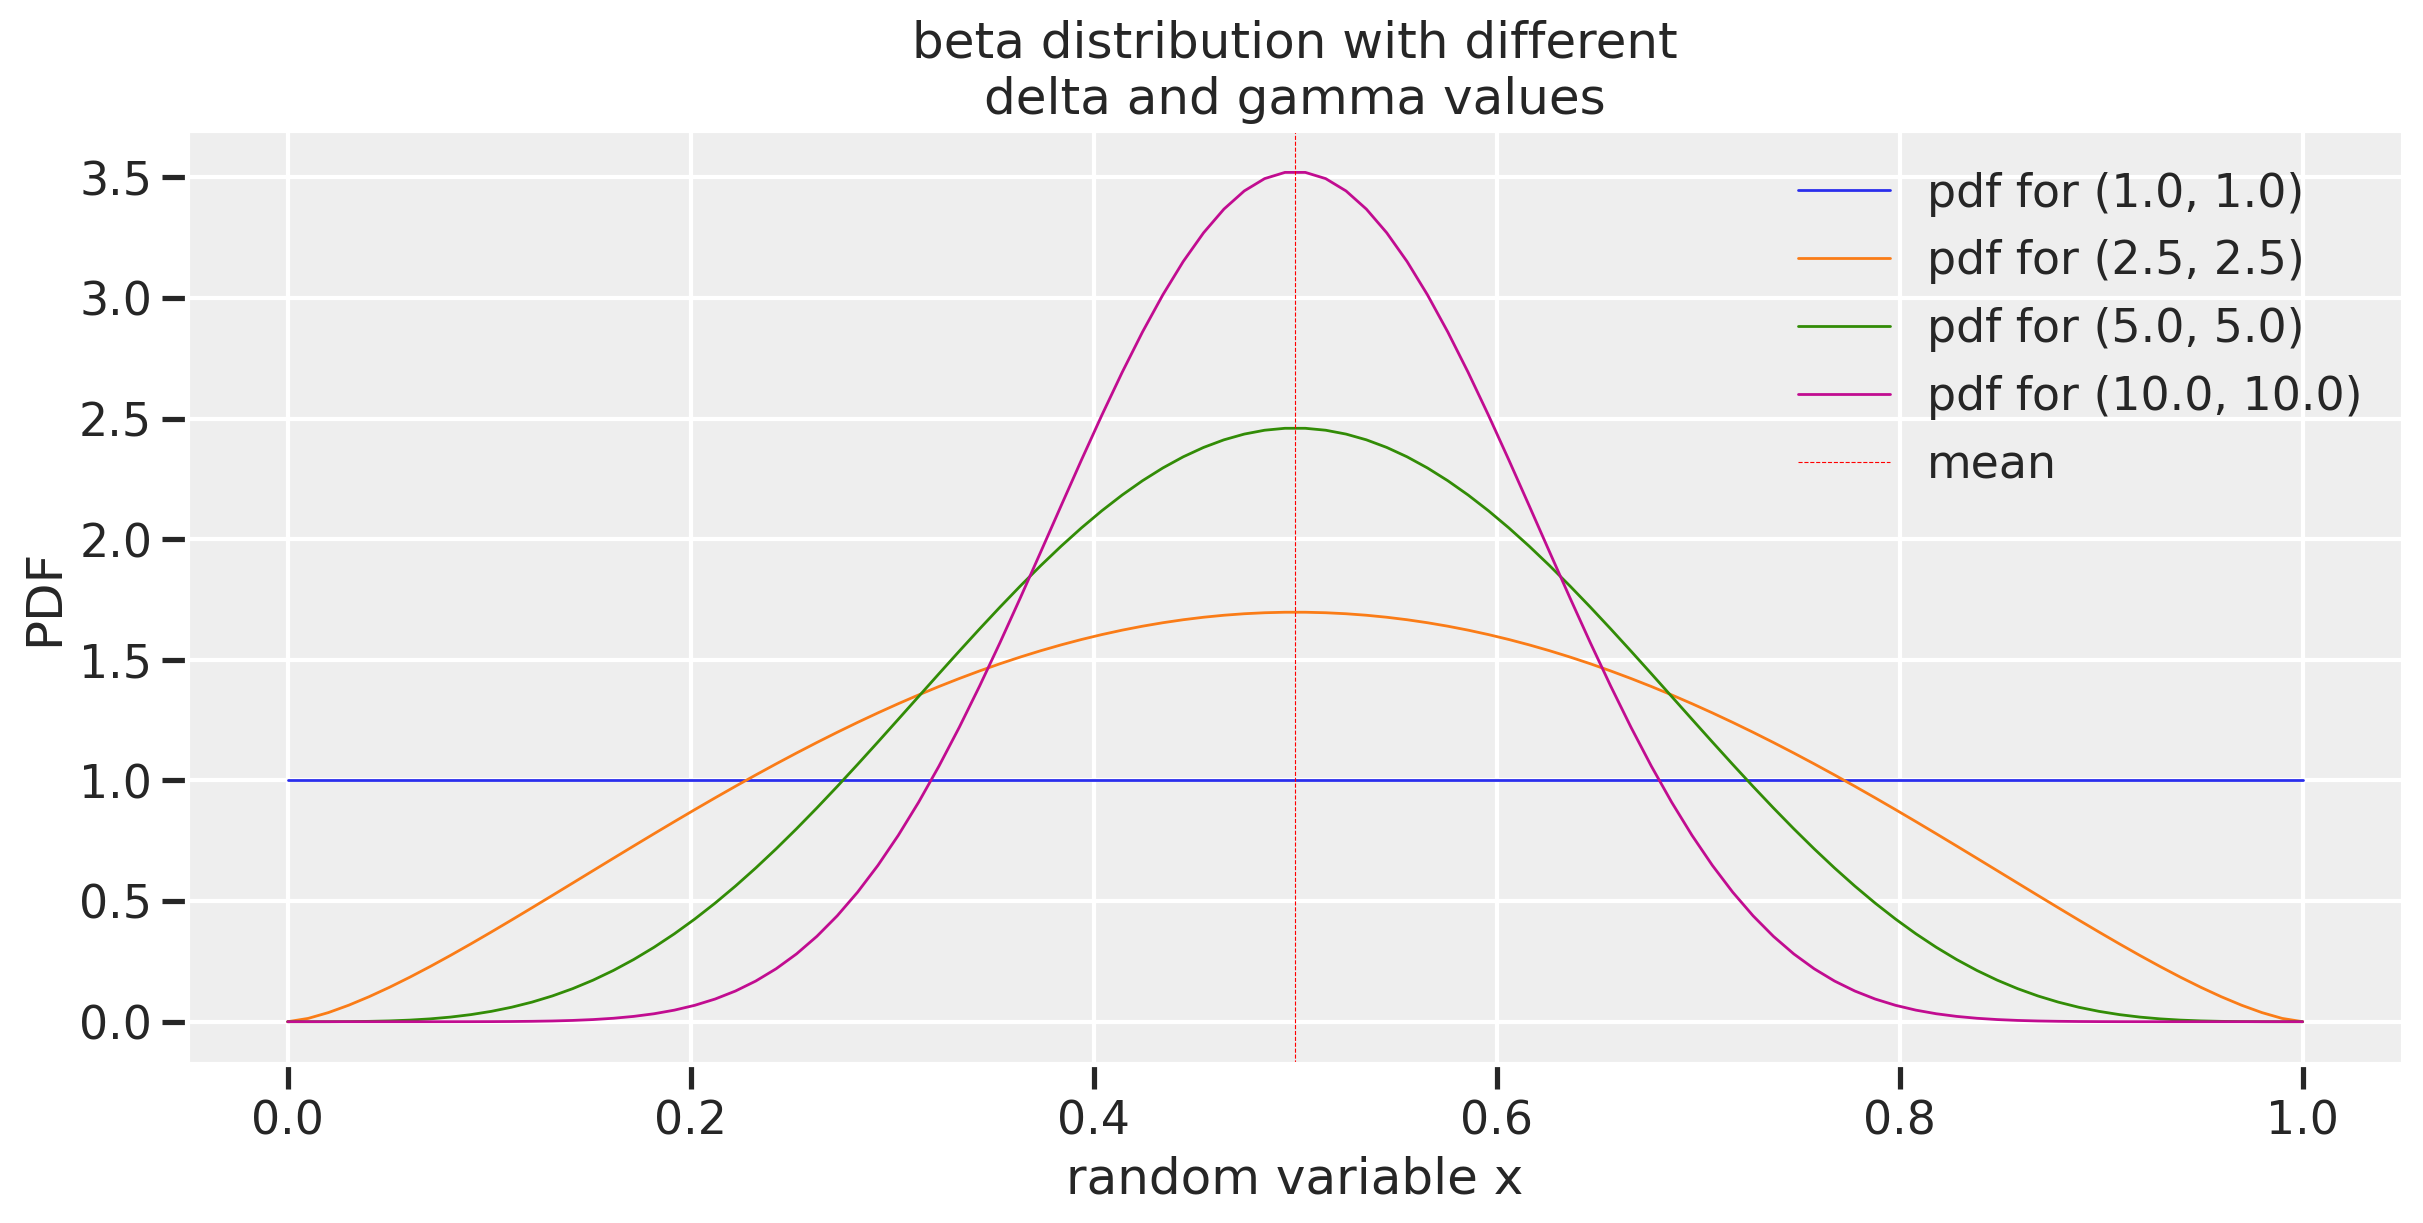

<IPython.core.display.Javascript object>

In [11]:
from scipy.stats import beta

# mu is the midpoint of the distribution
mu = 0.5
print("mu value: ", mu)

# Generate different values of alpha (a) and beta (b)
n_list = [2, 5, 10, 20]

f, ax1 = plt.subplots(figsize=(12, 6))
for n in n_list:
    a = mu * n
    b = n - a

    x = np.linspace(beta.ppf(0.00, a, b), beta.ppf(1.00, a, b), 100)
    this_label = "pdf for (" + str(a) + ", " + str(b) + ")"

    ax1.plot(x, beta.pdf(x, a, b), lw=1, label=this_label)

ax1.axvline(mu, lw=0.4, color="red", linestyle="dashed", label="mean")
ax1.set_title("beta distribution with different\ndelta and gamma values")
ax1.set_xlabel("random variable x")
ax1.set_ylabel("PDF")
ax1.legend()

In [25]:
df_primates.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,neocortex_prop,neocortex_prop_std,k_std,logmass,logmass_std
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,0.5516,-2.144217,-0.956680,0.667829,-0.463904
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,NaN,NaN,-0.830572,0.737164,-0.422348
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,NaN,NaN,-1.145842,0.920283,-0.312595
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,NaN,NaN,-1.019734,0.482426,-0.575027
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,NaN,NaN,-0.263087,0.783902,-0.394336


<IPython.core.display.Javascript object>

In [126]:
idx_miss.tolist() + idx_obs.tolist()

[1,
 2,
 3,
 4,
 8,
 13,
 14,
 16,
 18,
 20,
 22,
 25,
 0,
 5,
 6,
 7,
 9,
 10,
 11,
 12,
 15,
 17,
 19,
 21,
 23,
 24,
 26,
 27,
 28]

<IPython.core.display.Javascript object>

In [127]:
with pm.Model() as m15_5b:

    # hyperpriors
    # delta = pm.Beta("delta", alpha=2, beta=2)
    # gamma = pm.Exponential("gamma", 1)

    # priors
    a = pm.Normal("a", 0, 0.5)
    bB = pm.Normal("bB", 0, 1)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    # obs/imputed B with beta distribution (avoid standardizing)
    # alternate paramaterization for beta
    # Bi = pm.Beta("Bi", mu=delta, sigma=gamma, observed=df_primates["neocortex_prop"])
    # Modification in response to discourse message https://discourse.pymc.io/t/beta-distribution-failing-for-missing-value-imputation/8478/7
    idx_miss = df_primates.loc[df_primates["neocortex_prop"].isna(), "neocortex_prop"].index
    idx_obs = df_primates.loc[df_primates["neocortex_prop"].notna(), "neocortex_prop"].index
    Bi_miss = pm.Beta("Bi_miss", alpha=2, beta=2, shape = len(idx_miss))
    # Bi_miss = pm.Beta("Bi_miss", alpha=2, beta=2, shape = df_primates.loc[idx_miss, "neocortex_prop"])
    Bi_obs = pm.Beta("Bi_obs", alpha=1, beta=1, observed = df_primates.loc[idx_obs, "neocortex_prop"])
    Bi = pm.math.concatenate([Bi_miss, Bi_obs], axis=0)     # cleaner way to do this?

    # linear model, changed the order of logmass_std to match Bi index
    mu = a + bB * (Bi - 0.67) + bM * df_primates.loc[idx_miss.tolist() + idx_obs.tolist(), "logmass_std"]
    
    # likelihood, changed the order of k_std to match Bi index
    K = pm.Normal("K", mu, sigma, observed=df_primates.loc[idx_miss.tolist() + idx_obs.tolist(), "k_std"])

    # sample
    trace_m15_5b = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Bi_miss, sigma, bM, bB, a]
INFO:pymc3:NUTS: [Bi_miss, sigma, bM, bB, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


<IPython.core.display.Javascript object>

In [128]:
az.summary(trace_m15_5b)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.032,0.185,-0.268,0.321,0.002,0.003,5576.0,2131.0,5570.0,3093.0,1.0
bB,0.583,0.864,-0.848,1.901,0.013,0.011,4396.0,3091.0,4397.0,3300.0,1.0
bM,-0.315,0.173,-0.599,-0.044,0.002,0.002,6161.0,4393.0,6151.0,2890.0,1.0
sigma,0.980,0.138,0.765,1.194,0.002,0.001,5334.0,5173.0,5317.0,2866.0,1.0
Bi_miss[0],0.475,0.219,0.108,0.809,0.003,0.002,6329.0,4954.0,6445.0,2426.0,1.0
Bi_miss[1],0.462,0.223,0.119,0.817,0.003,0.002,5894.0,5084.0,5829.0,3211.0,1.0
Bi_miss[2],0.470,0.224,0.103,0.812,0.003,0.002,6370.0,5090.0,6370.0,2642.0,1.0
Bi_miss[3],0.499,0.221,0.155,0.860,0.003,0.002,6872.0,6101.0,6855.0,2767.0,1.0
Bi_miss[4],0.543,0.223,0.218,0.922,0.003,0.002,6069.0,5730.0,6234.0,3237.0,1.0
Bi_miss[5],0.505,0.221,0.148,0.857,0.003,0.002,6798.0,5884.0,6718.0,2719.0,1.0


<IPython.core.display.Javascript object>

Asked pymc discourse for [help](https://discourse.pymc.io/t/beta-distribution-failing-for-missing-value-imputation/8478) and got a response. From Ricardo:

```
Bi_missing has two negative intial values as you can see in the error message. The problem is that in the current PyMC version imputed variables are not transformed as default variables are. That means imputation is not very stable for constrained variables.

This is fixed in the upcoming version of PyMC. In the meantime I would suggest you split the observed and missing variables into two separate Betas
```


Text(0, 0.5, 'Beta prior on missing')

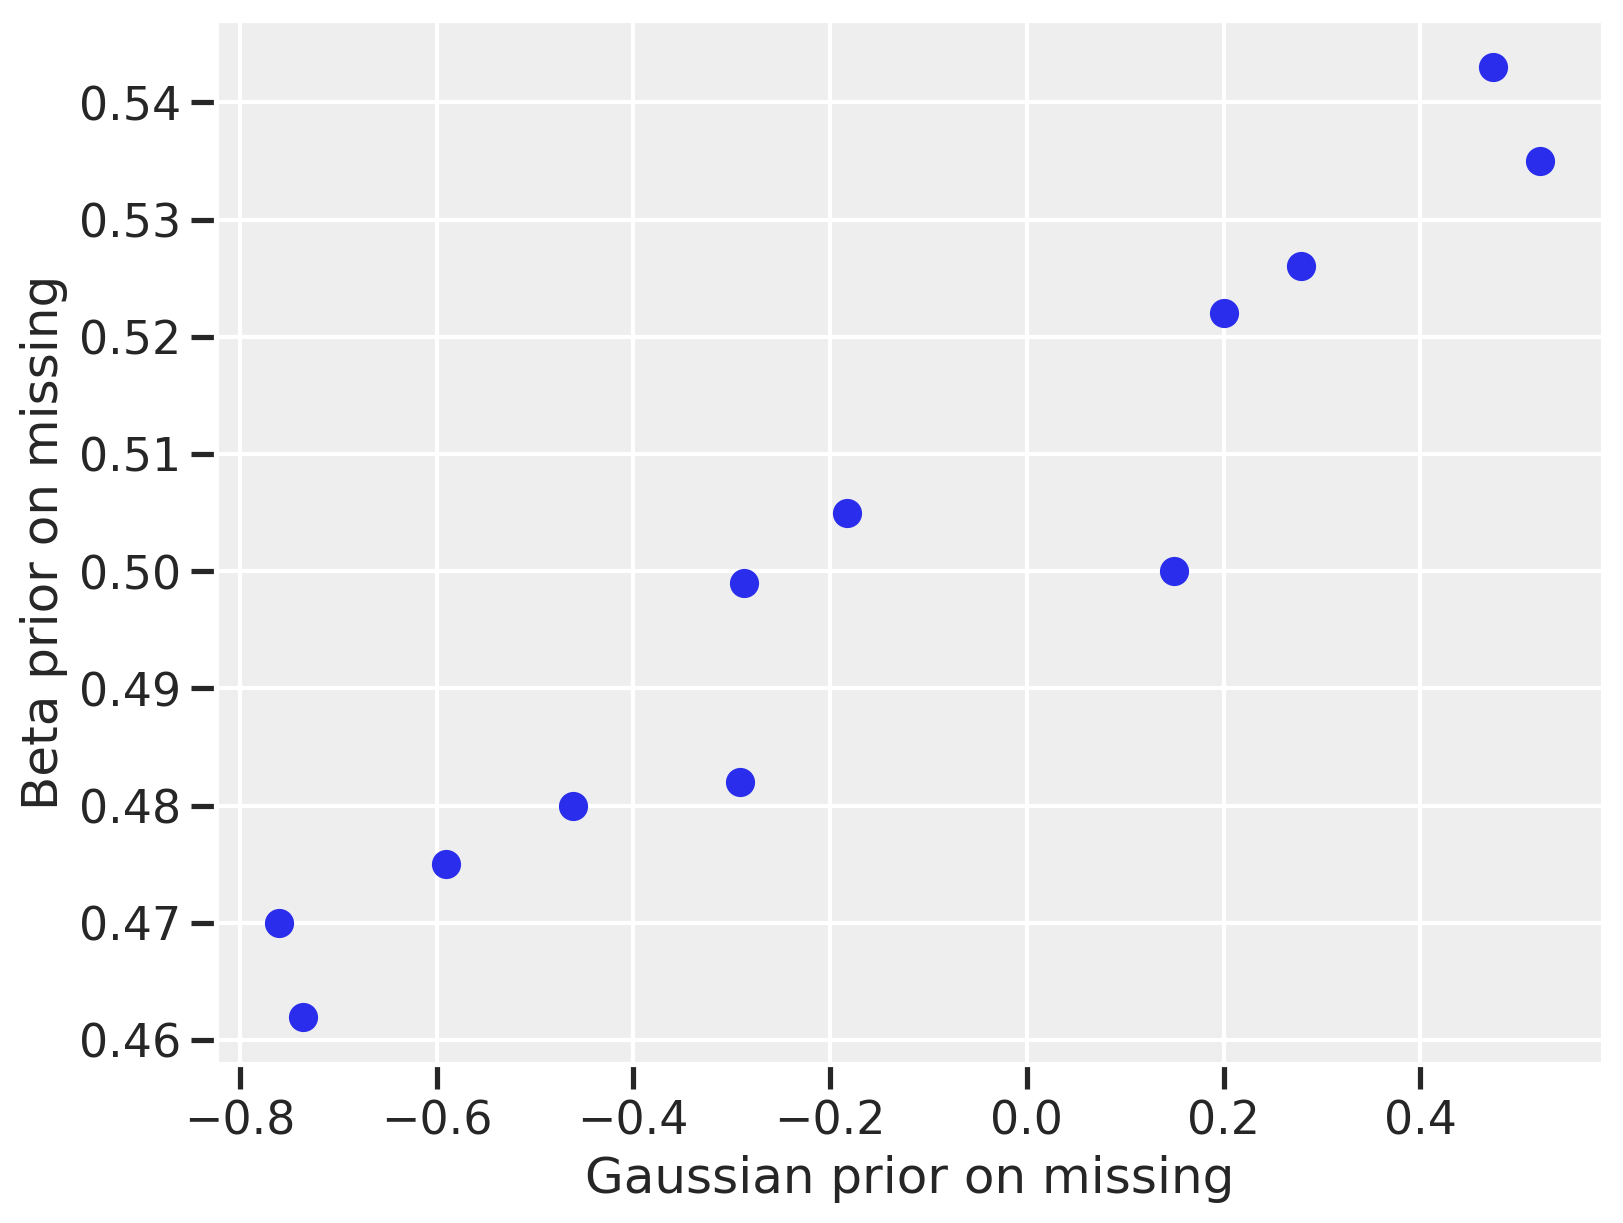

<IPython.core.display.Javascript object>

In [129]:
f, ax1 = plt.subplots(figsize=(8,6))
ax1.scatter(
    az.summary(trace_m15_5a, var_names='Bi_missing')['mean'],
    az.summary(trace_m15_5b, var_names='Bi_miss')['mean']
    )
ax1.set_xlabel('Gaussian prior on missing')
ax1.set_ylabel('Beta prior on missing')

# 15M3

Repeat the divorce data measurement error models, but this time double the standard errors. Can you explain how doubling the standard errors impacts inference?

Why do we need to do this?
```
D_sd = d$Divorce.SE / sd( d$Divorce )
```
Per Marco: "Make sure standard error is on same scale of divorce. Standardize divorce so also need to standardize the standard error."

In [30]:
DATA = "/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking/Data/"
df_divorce = pd.read_csv(DATA + "WaffleDivorce.csv", sep=";")
df_divorce["2_Divorce SE"] = 2 * df_divorce["Divorce SE"]
df_divorce["log_Population"] = np.log(df_divorce["Population"])
df_divorce.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,2_Divorce SE,log_Population
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,1.58,1.564441
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,4.10,-0.342490
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,1.48,1.845300
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,2.44,1.071584
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.48,3.617652


<IPython.core.display.Javascript object>

Text(0.5, 1.0, '2 x Original SE')

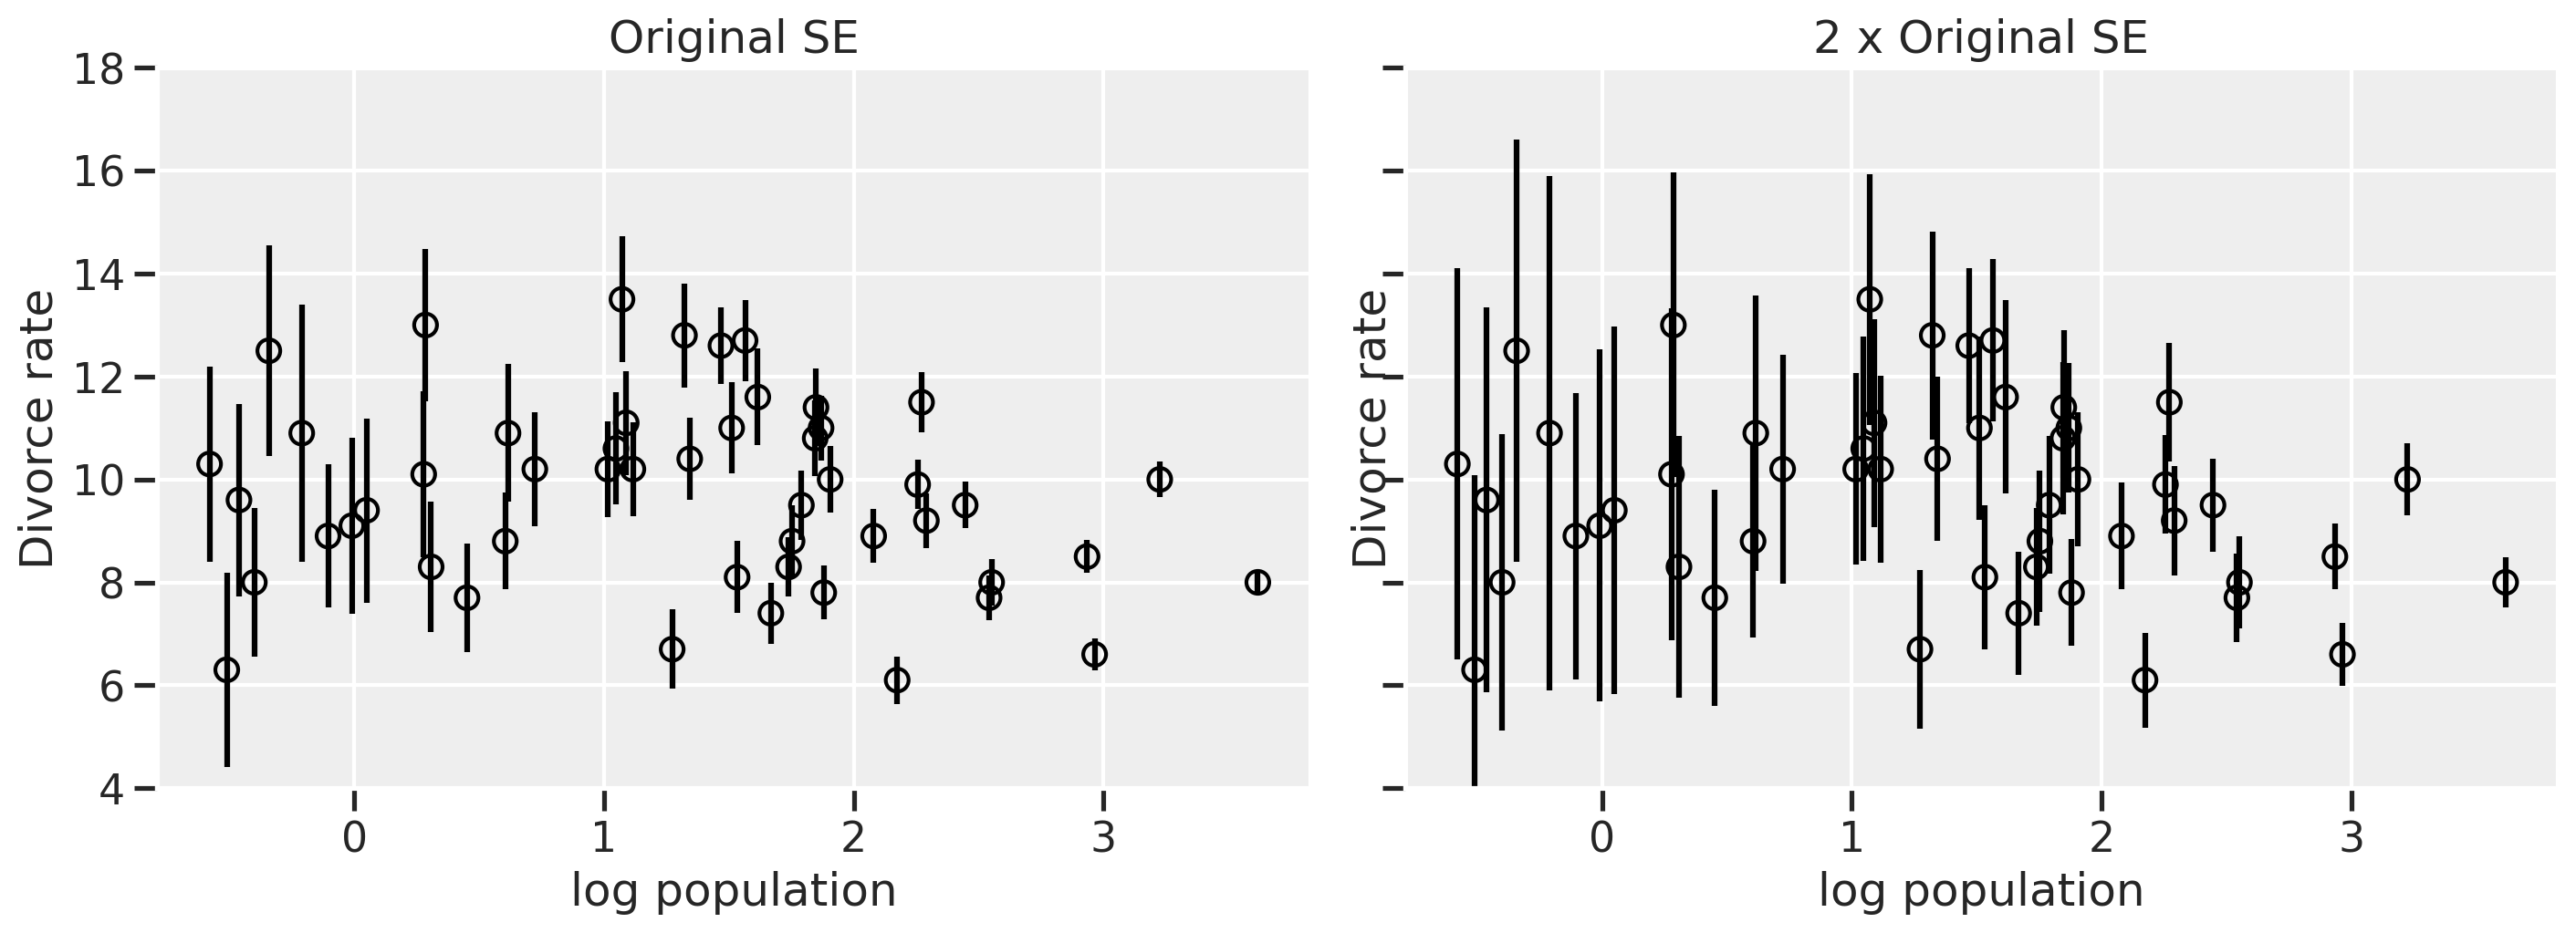

<IPython.core.display.Javascript object>

In [31]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
# first plot, code from repo
ax.scatter(
    df_divorce["log_Population"],
    df_divorce["Divorce"],
    edgecolor="k",
    facecolor="none",
)
ax.errorbar(
    df_divorce["log_Population"],
    df_divorce["Divorce"],
    yerr=df_divorce["Divorce SE"],
    fmt="none",
    c="k",
)

ax.set_ylim(4, 18)
ax.set_xlabel("log population")
ax.set_ylabel("Divorce rate")
ax.set_title("Original SE")

# second plot
ax2.scatter(
    df_divorce["log_Population"],
    df_divorce["Divorce"],
    edgecolor="k",
    facecolor="none",
)
ax2.errorbar(
    df_divorce["log_Population"],
    df_divorce["Divorce"],
    yerr=df_divorce["2_Divorce SE"],
    fmt="none",
    c="k",
)

# ax2.set_ylim(4, 15)
ax2.set_xlabel("log population")
ax2.set_ylabel("Divorce rate")
ax2.set_title("2 x Original SE")

Recall that we have this model:

$$ D_{\text{OBS,i}} \sim \text{Normal}(D_{\text{TRUE,i}},D_{\text{SE,i}}) \tag{distribution for observed values} $$
$$ \mu_i = \alpha + \beta_AA_i + \beta_MM_i \tag{linear model to assess A → D} $$
$$ \alpha \sim \text{Normal}(0, 0.2) $$
$$ \beta_A \sim \text{Normal}(0, 0.5) $$
$$ \beta_M \sim \text{Normal}(0, 0.5) $$
$$ \sigma \sim \text{Exponential}(1) $$

In [32]:
# pymc repo code (original model)
D_obs = standardize(df_divorce["Divorce"])
D_sd = df_divorce["Divorce SE"] / df_divorce["Divorce"].std()
M = standardize(df_divorce["Marriage"])
A = standardize(df_divorce["MedianAgeMarriage"])
N = len(df_divorce)

with pm.Model() as m15_1:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)

    mu = a + bA * A + bM * M  # linear model to assess A -> D
    D_true = pm.Normal("D_true", mu, sigma, shape=N)  # distribution for true values
    
    
    # distribution for observed values
    D = pm.Normal(
        "D_obs", D_true, D_sd, observed=D_obs
    )  

    trace_m15_1 = pm.sample(return_inferencedata=True, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D_true, a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [33]:
# pymc repo code with 2 SE
D_obs = standardize(df_divorce["Divorce"])
D_sd = df_divorce["2_Divorce SE"] / df_divorce["Divorce"].std()
M = standardize(df_divorce["Marriage"])
A = standardize(df_divorce["MedianAgeMarriage"])
N = len(df_divorce)

with pm.Model() as m15_1b:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)

    mu = a + bA * A + bM * M  # linear model to assess A -> D
    D_true = pm.Normal("D_true", mu, sigma, shape=N)  # distribution for true values

    # distribution for observed values
    D = pm.Normal("D_obs", D_true, D_sd, observed=D_obs)

    trace_m15_1b = pm.sample(
        return_inferencedata=True, random_seed=RANDOM_SEED, target_accept=0.95
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D_true, a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
There were 432 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5869107984776012, but should be close to 0.95. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8456300766670493, but should be close to 0.95. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

Note that I had to increase `target_accept`.

## Impact on parameters

In [37]:
az.summary(trace_m15_1, var_names=["bM", "bA", "a", "sigma"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,0.045,0.166,-0.218,0.312,0.004,0.003,1888.0,1888.0,1891.0,2404.0,1.0
bA,-0.619,0.163,-0.875,-0.360,0.004,0.003,1778.0,1778.0,1778.0,2586.0,1.0
a,-0.055,0.096,-0.198,0.105,0.002,0.001,2669.0,2336.0,2677.0,2555.0,1.0
sigma,0.598,0.109,0.436,0.781,0.003,0.002,976.0,976.0,939.0,749.0,1.0


<IPython.core.display.Javascript object>

In [38]:
az.summary(trace_m15_1b, var_names=["bM", "bA", "a", "sigma"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,0.213,0.191,-0.082,0.500,0.020,0.014,89.0,89.0,80.0,318.0,1.05
bA,-0.628,0.166,-0.864,-0.358,0.014,0.010,136.0,136.0,146.0,447.0,1.04
a,-0.118,0.094,-0.274,0.028,0.005,0.004,291.0,291.0,277.0,441.0,1.03
sigma,0.146,0.106,0.008,0.298,0.025,0.018,17.0,17.0,15.0,21.0,1.19


<IPython.core.display.Javascript object>

In [45]:
az.summary(trace_m15_1b)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,0.213,0.191,-0.082,0.500,0.020,0.014,89.0,89.0,80.0,318.0,1.05
bA,-0.628,0.166,-0.864,-0.358,0.014,0.010,136.0,136.0,146.0,447.0,1.04
a,-0.118,0.094,-0.274,0.028,0.005,0.004,291.0,291.0,277.0,441.0,1.03
D_true[0],0.324,0.218,-0.001,0.649,0.010,0.009,512.0,317.0,319.0,834.0,1.04
D_true[1],0.659,0.337,0.109,1.198,0.023,0.017,206.0,206.0,196.0,343.0,1.02
D_true[2],0.052,0.200,-0.239,0.349,0.007,0.008,925.0,293.0,747.0,693.0,1.05
D_true[3],1.149,0.319,0.651,1.692,0.020,0.014,257.0,257.0,243.0,399.0,1.02
D_true[4],-0.647,0.181,-0.903,-0.349,0.016,0.011,128.0,126.0,126.0,545.0,1.03
D_true[5],0.278,0.261,-0.118,0.711,0.017,0.012,228.0,228.0,201.0,424.0,1.02
D_true[6],-1.105,0.234,-1.455,-0.751,0.013,0.009,341.0,341.0,289.0,888.0,1.03


<IPython.core.display.Javascript object>

Text(0.5, 1.0, '2 x SE model')

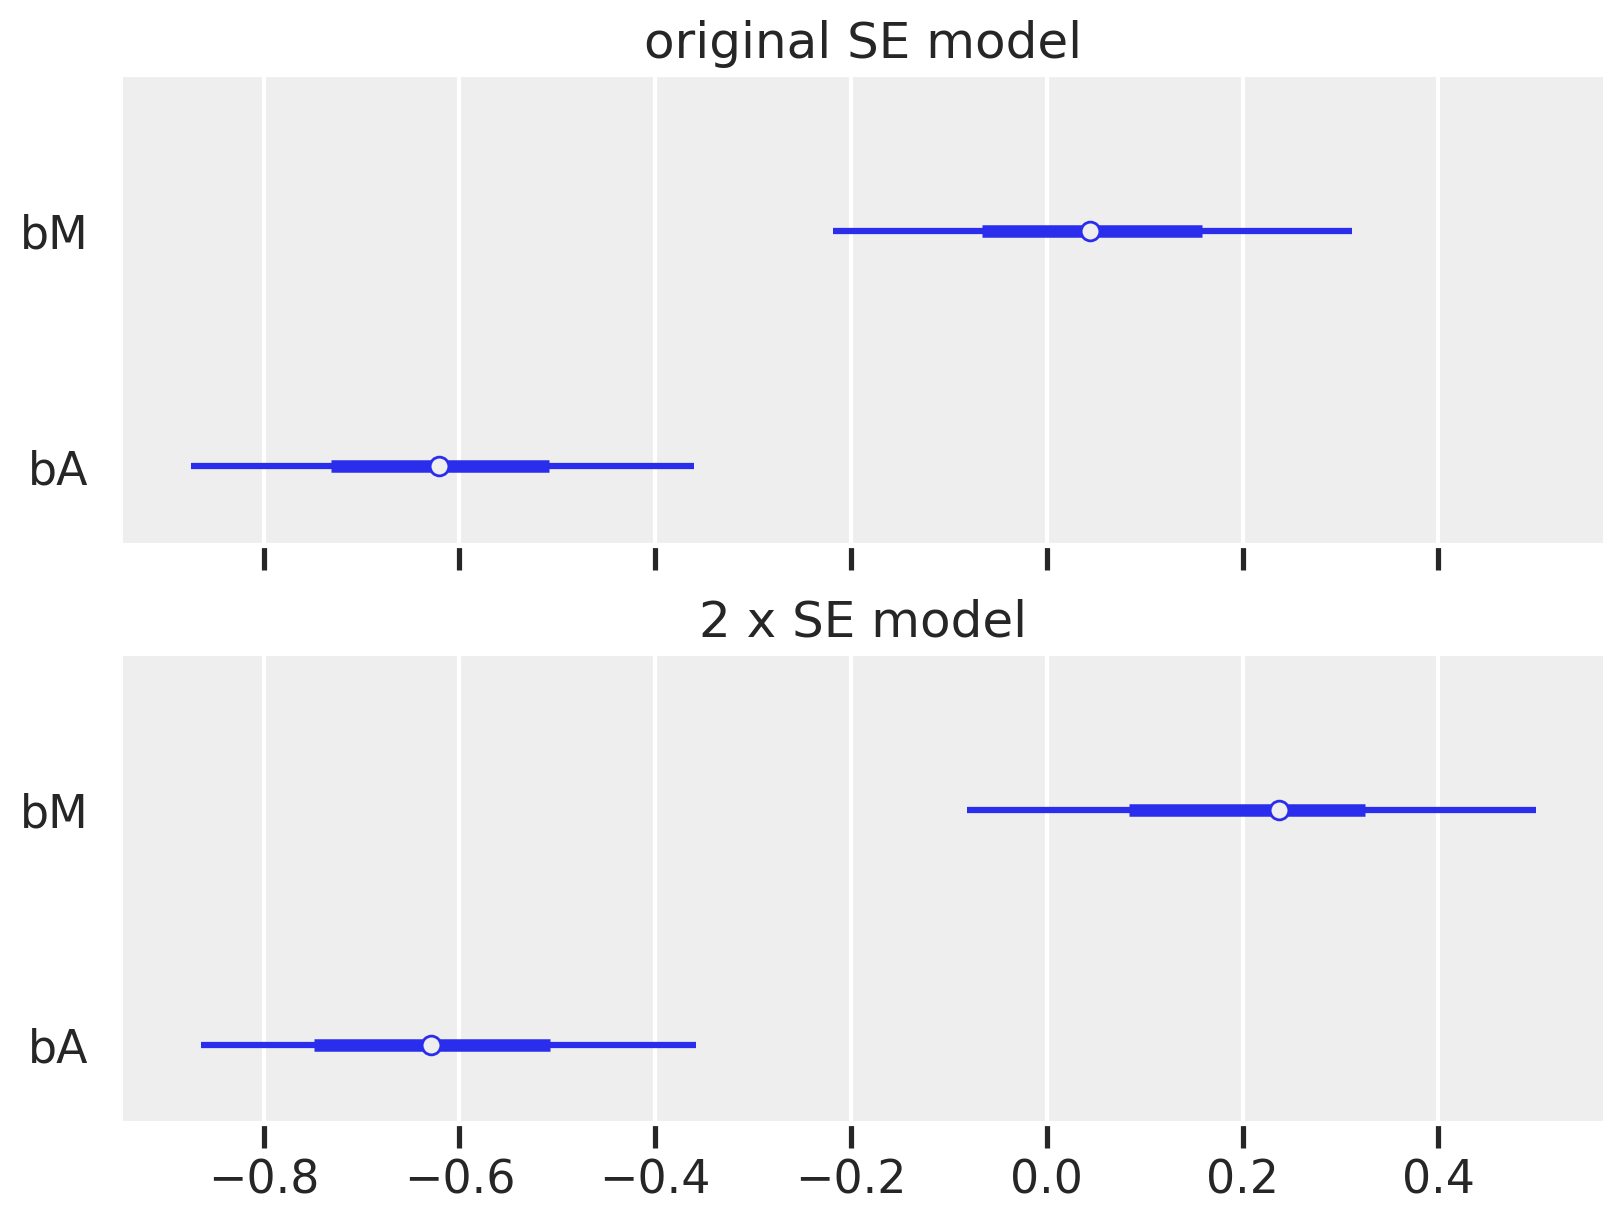

<IPython.core.display.Javascript object>

In [36]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
az.plot_forest(trace_m15_1, var_names=["bM", "bA"], combined=True, ax=ax1)
ax1.set_title("original SE model")

az.plot_forest(trace_m15_1b, var_names=["bM", "bA"], combined=True, ax=ax2)
ax2.set_title("2 x SE model")

## Impact on the outcome scale

Text(0.5, 0, 'Log population')

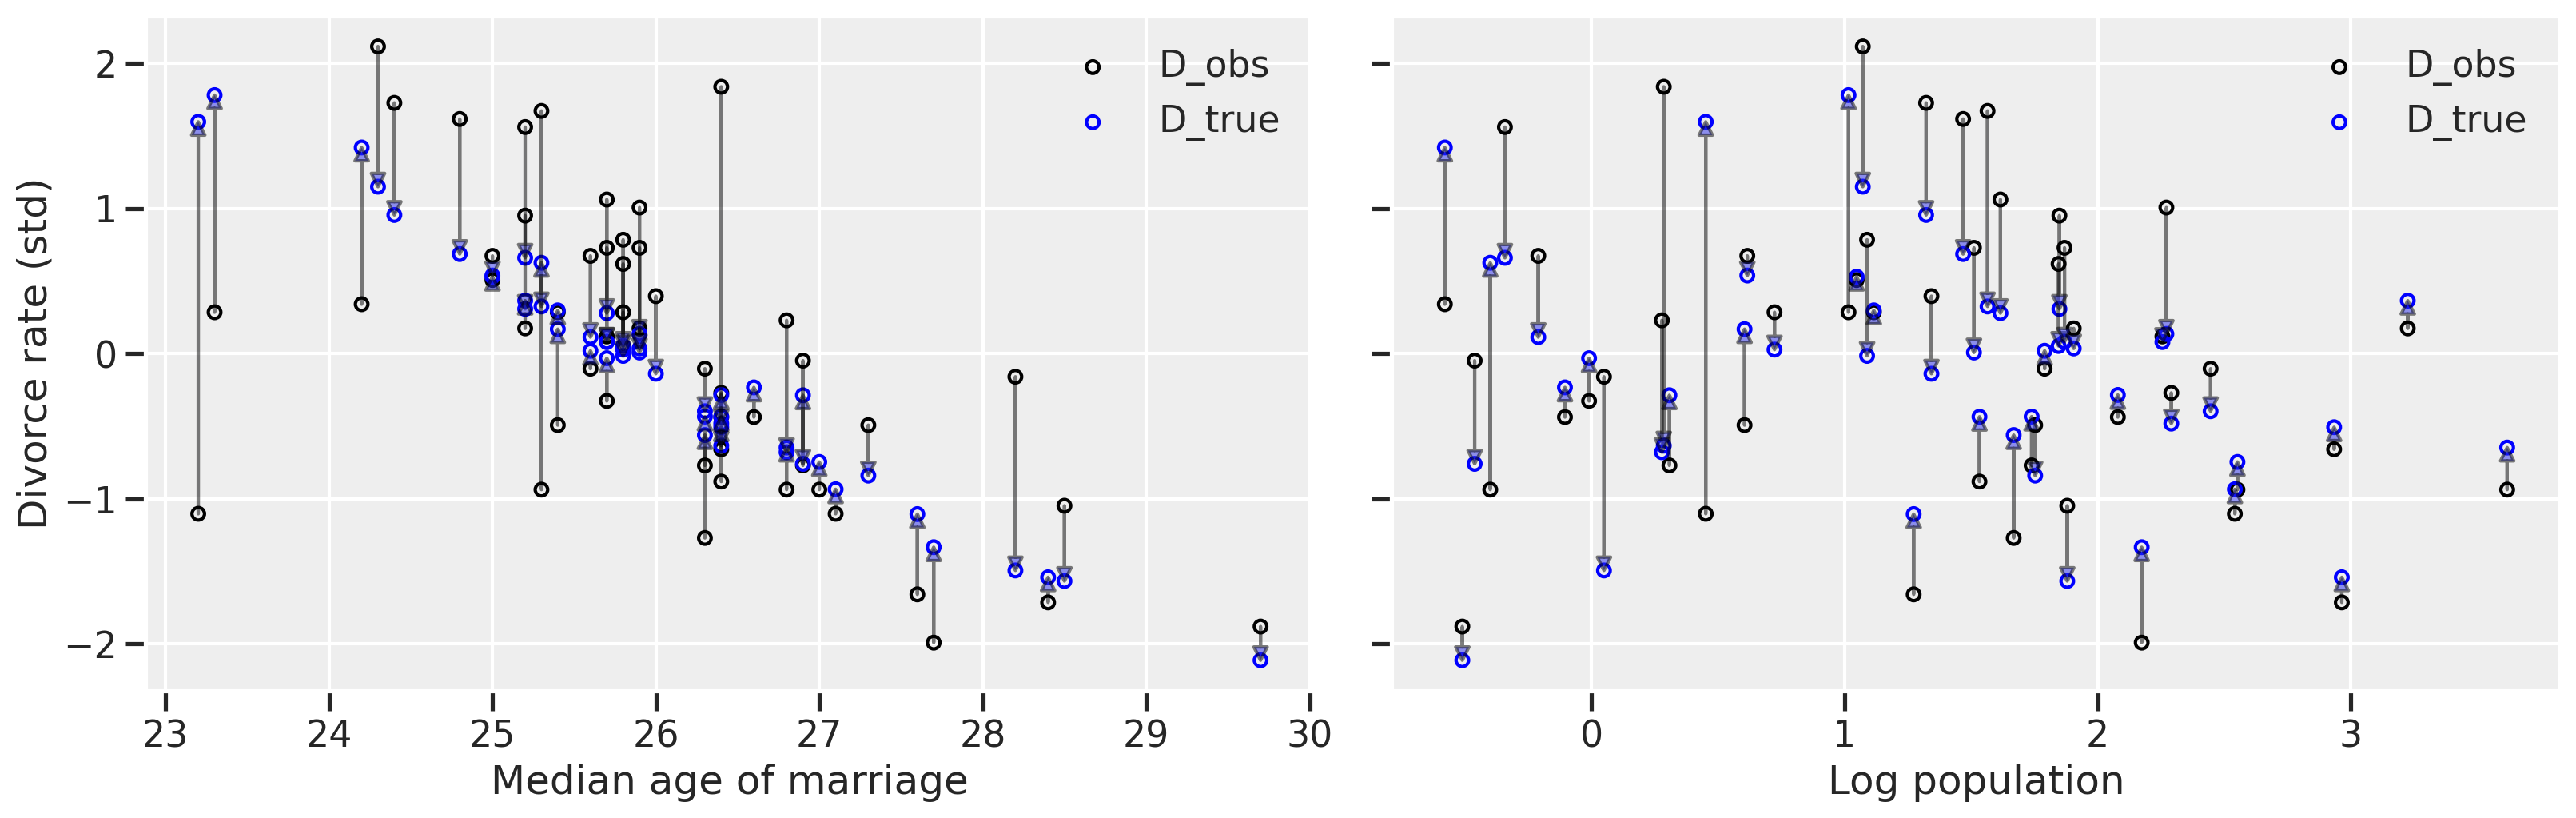

<IPython.core.display.Javascript object>

In [41]:
D_true = az.summary(trace_m15_1b, var_names="D_true")["mean"]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
ax1.scatter(
    df_divorce["MedianAgeMarriage"],
    D_obs,
    facecolors="none",
    edgecolors="k",
    s=2 ** 5,
    label="D_obs",
)

ax1.scatter(
    df_divorce["MedianAgeMarriage"],
    D_true,
    facecolors="none",
    edgecolors="blue",
    s=2 ** 5,
    label="D_true",
)

for i in range(len(df_divorce["MedianAgeMarriage"])):
    ax1.annotate(
        "",
        xy=[df_divorce["MedianAgeMarriage"][i], D_true[i]],
        xytext=[df_divorce["MedianAgeMarriage"][i], D_obs[i]],
        # arrowprops=(width=2),
        arrowprops=dict(
            alpha=0.5, width=0.01, headwidth=6, headlength=6, shrink=2
        ),  # arrowstyle="->"),
        # color="gray",
    )
ax1.legend()
ax1.set_ylabel("Divorce rate (std)")
ax1.set_xlabel("Median age of marriage")

# Second plot
ax2.scatter(
    df_divorce["log_Population"],
    D_obs,
    facecolors="none",
    edgecolors="k",
    s=2 ** 5,
    label="D_obs",
)

ax2.scatter(
    df_divorce["log_Population"],
    D_true,
    facecolors="none",
    edgecolors="blue",
    s=2 ** 5,
    label="D_true",
)

for i in range(len(df_divorce["log_Population"])):
    ax2.annotate(
        "",
        xy=[df_divorce["log_Population"][i], D_true[i]],
        xytext=[df_divorce["log_Population"][i], D_obs[i]],
        # arrowprops=(width=2),
        arrowprops=dict(
            alpha=0.5, width=0.01, headwidth=6, headlength=6, shrink=2
        ),  # arrowstyle="->"),
        # color="gray",
    )
ax2.legend()
ax2.set_xlabel("Log population")

# 15M4

Simulate the following DAG: X -> Y -> Z. 

Now build a model predicting Y using both X and Z. What is the confound that arises?

$$ Y =\alpha + \beta_1X + \beta_2Z $$

In [133]:
# start with x coming from random draws of a normal distribution around 0
X = stats.norm.rvs(0, 1, size=100)
bX_sim = 0.7

# make y come from random draws of a normal distribution around x
# use a known coefficient
Y = bX_sim * stats.norm.rvs(X, 1, size=100)
bY_sim = 0.3

# make z come from random draws of a normal distribution around x
Z = np.random.normal(Y, 1, size=100)
# Z = np.random.normal(0, 1, size=100)*Y +

df_sim = pd.DataFrame({"X": X, "Y": Y, "Z": Z})

<IPython.core.display.Javascript object>

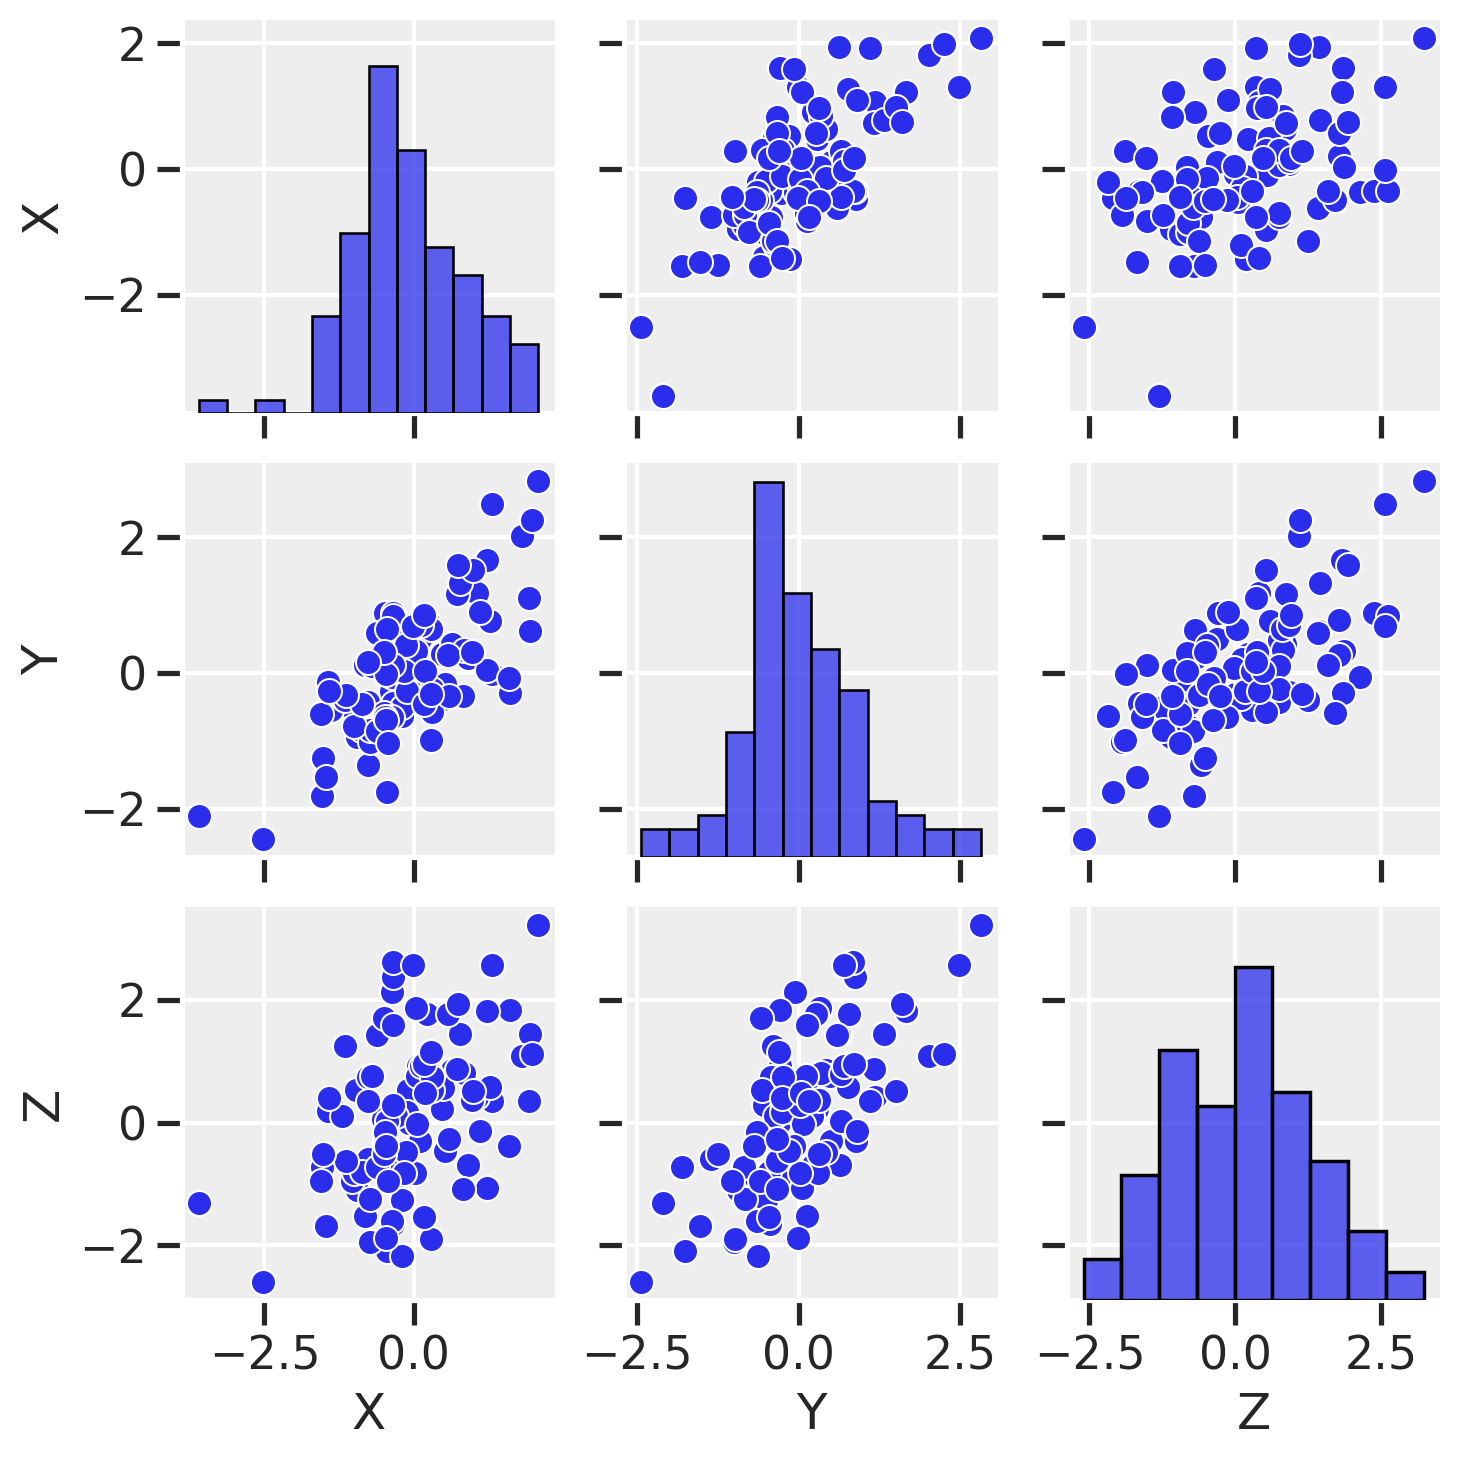

<IPython.core.display.Javascript object>

In [134]:
sns.pairplot(df_sim)

## Using only X as predictor variable

In [138]:
with pm.Model() as m15m4a:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = bx * df_sim['X']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4a = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4a = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bx]
INFO:pymc3:NUTS: [sigma, bx]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

In [137]:
sm.OLS(df_sim["Y"], df_sim["X"]).fit().params

X    0.652115
dtype: float64

<IPython.core.display.Javascript object>

In [139]:
az.summary(trace_m15m4a)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bx,0.650,0.067,0.542,0.758,0.001,0.001,3651.0,3640.0,3655.0,2880.0,1.0
sigma,0.648,0.047,0.570,0.718,0.001,0.001,3384.0,3353.0,3410.0,2233.0,1.0


<IPython.core.display.Javascript object>

## Using X and Z as predictor variables

In [140]:
with pm.Model() as m15m4b:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    bz = pm.Normal("bz", 0, 2)
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = bx * df_sim['X'] + bz * df_sim['Z']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4b = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4b = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, bx]
INFO:pymc3:NUTS: [sigma, bz, bx]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


<IPython.core.display.Javascript object>

In [141]:
sm.OLS(df_sim["Y"], df_sim[["X", "Z"]]).fit().params

X    0.478039
Z    0.329897
dtype: float64

<IPython.core.display.Javascript object>

In [142]:
az.summary(trace_m15m4b)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bx,0.477,0.062,0.375,0.571,0.001,0.001,3380.0,3380.0,3389.0,2933.0,1.0
bz,0.330,0.049,0.252,0.407,0.001,0.001,3566.0,3566.0,3576.0,2666.0,1.0
sigma,0.536,0.038,0.473,0.593,0.001,0.000,5057.0,5020.0,4925.0,2819.0,1.0


<IPython.core.display.Javascript object>

## Plot comparison

Text(0.5, 1.0, 'X (causal) and Z (descendant)')

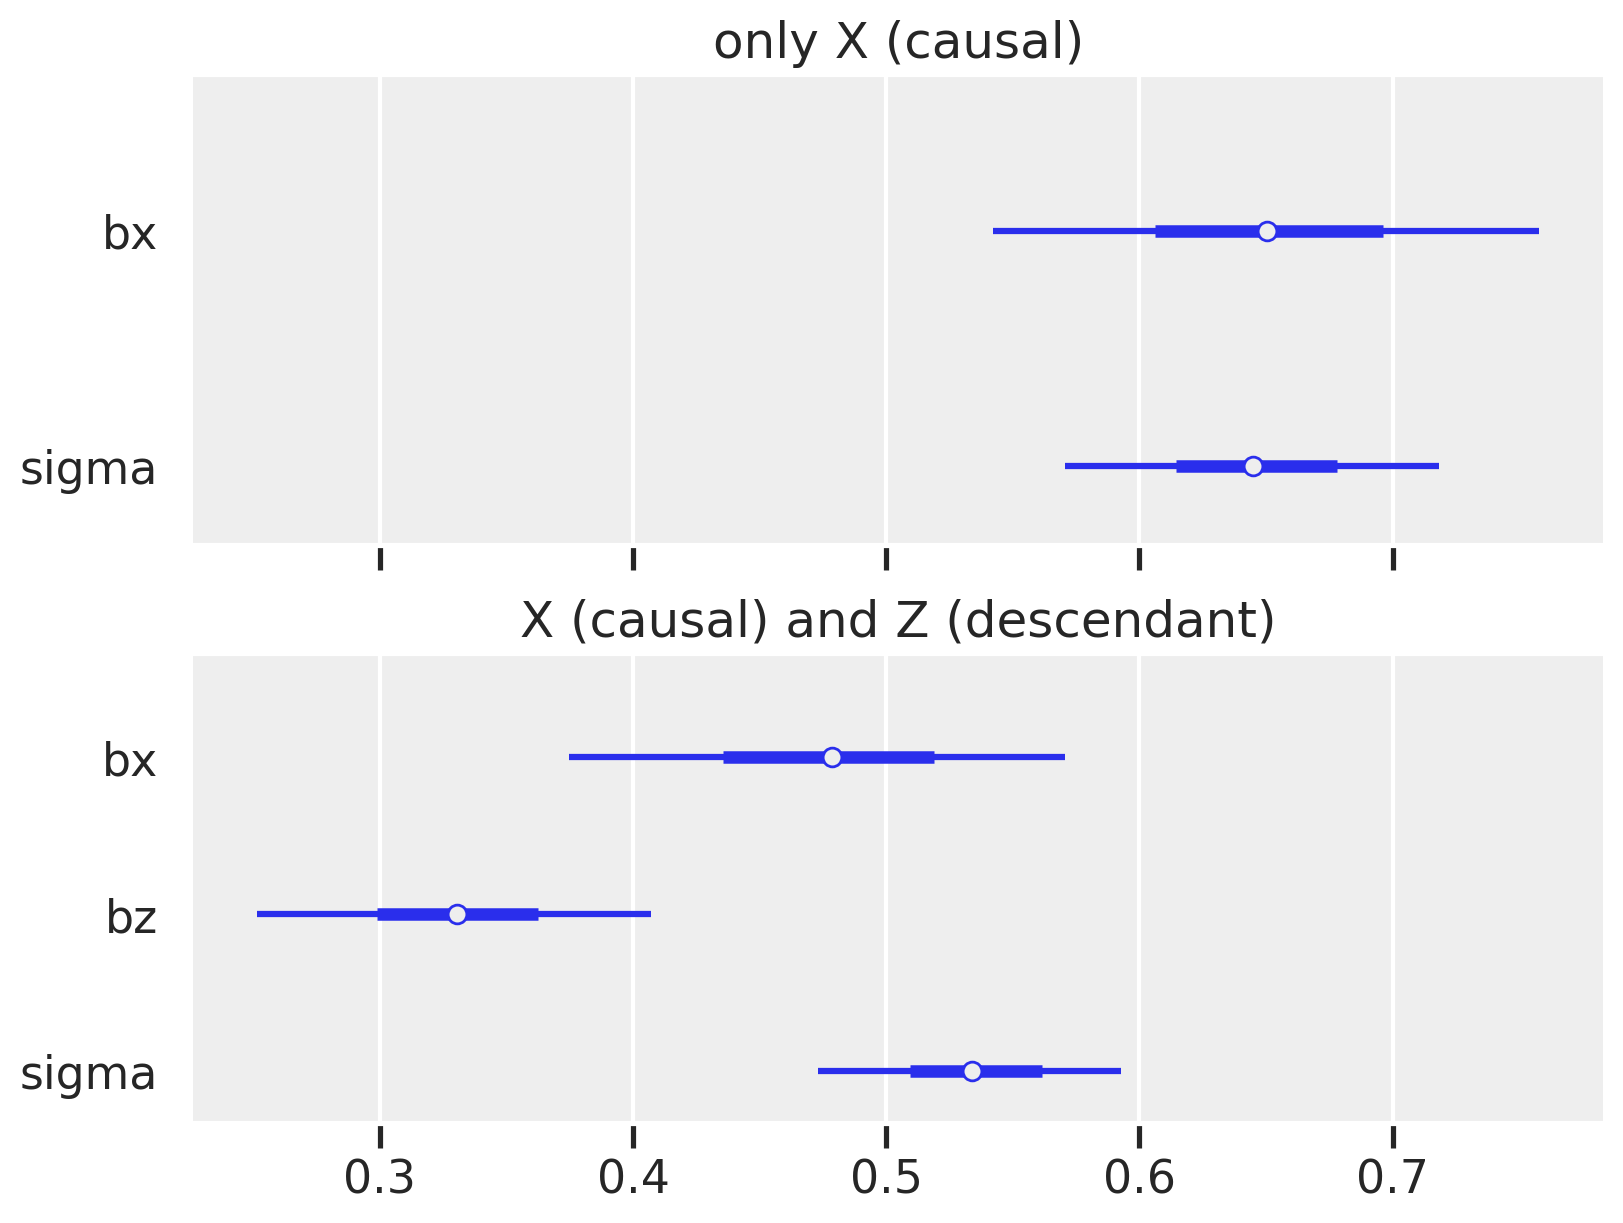

<IPython.core.display.Javascript object>

In [143]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
az.plot_forest(trace_m15m4a, combined=True, ax=ax1)
ax1.set_title("only X (causal)")

az.plot_forest(trace_m15m4b, combined=True, ax=ax2)
ax2.set_title("X (causal) and Z (descendant)")

Marco's tip:
- pretend z is like Y observed
- measurement error ....
- like shrinkage for coefficient

# 15H7

This is a hard problem, so don’t feel bad if you struggle with it. Getting a piece
of the solution is good. It might seem arbitrary at first. But it has a similar structure
to a lot of problems in biology, from genetics to archaeology to the comparative
method. It is likely possible for you to quickly intuit a reasonable answer. Justifying
that answer with probability theory is the problem.

Some lad named Andrew made an eight-sided spinner. He wanted to know if it
is fair. So he spun it a bunch of times, recording the counts of each value. Then he
accidentally spilled coffee over the 4s and 5s. The surviving data are:

```
Value      1  2  3  4  5  6  7  8
Frequency 18 19 22 NA NA 19 20 22
```

Your job is to impute the two missing values (the NA values) in the table above.
Andrew doesn’t remember how many times he spun the spinner. So you will have to
assign a prior distribution for the total number of spins and then marginalize over
the unknown total. Andrew is not sure the spinner is fair (every value is equally
likely), but he’s confident that none of the values is twice as likely as any other. Use a
Dirichlet distribution to capture this prior belief. Plot the joint posterior distribution
of 4s and 5s.

Concepts:

- Dirichelet distribution
- Bayesian imputation for missing values

## Data setup

In [6]:
# I'll use Python 0 indexing for the value
df_spinner = pd.DataFrame(
    {"value": range(8), "frequency": [18, 19, 22, None, None, 19, 20, 22]}
)

df_spinner

,value,frequency
0,0,18.0
1,1,19.0
2,2,22.0
3,3,NaN
4,4,NaN
5,5,19.0
6,6,20.0
7,7,22.0


<IPython.core.display.Javascript object>

## Model equation

## Simulation

In [130]:
# For simulation
with pm.Model() as m1:
    
    # likelihood with known parameters
    W = pm.Binomial("W", n=2, p=0.7)
    # sample
    prior_checks = pm.sample_prior_predictive(samples=30)

prior_checks['W']

array([1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1,
       1, 1, 1, 1, 2, 2, 2, 2])

<IPython.core.display.Javascript object>

In [131]:
# For simulation
with pm.Model() as m15h7_sim:
    
    # likelihood with known parameters
    f = pm.Dirichlet("f", a=range(8))
    # sample
    prior_checks = pm.sample_prior_predictive(samples=160)

prior_checks['f']

ValueError: Domain error in arguments.

<IPython.core.display.Javascript object>

In [132]:
quantiles = np.array([0.2, 0.2, 0.6])  # specify quantiles
alpha = np.array([0.4, 5, 15])  # specify concentration parameters
stats.dirichlet.pdf(quantiles, alpha)

0.2843831684937255

<IPython.core.display.Javascript object>

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Fri Jul 02 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
matplotlib: 3.3.4
arviz     : 0.11.1
pymc3     : 3.11.0
daft      : 0.1.0
json      : 2.0.9
numpy     : 1.20.1
seaborn   : 0.11.1
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>